In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils.utils import get_video_properties, get_contours_from_segmasks, get_contour_stats, extract_frames_from_video
from utils.egocentric_utils import process_images_with_extents, process_images_with_masks

In [2]:
# compile list to redo
# # moss
# 2024_0311_153344_021_trimmed_10sec_ts28-te38_cropped_1050-1800-800-2000_seg DONE
# 2024_0312_200610_055_trimmed_10sec_ts121-te131_cropped_200-850-0-600_seg.mp4
# 2024_0312_200031_053_trimmed_15sec_ts74-te89_cropped_250-1250-0-1100_seg.mp4 DONE
# 2024_0311_152452_018_trimmed_15sec_ts0-te15_cropped_700-2100-400-1800_seg.mp4 DONE

# # birdbath
# 2024_0229_115124_054_subclip_8sec_ts324-te332.mp4 only in 480x480 thus far

# previous fig 
#vid_filename = "2024_0201_152845_091_10sec" DONE
# "2024_0216_161747_055_20sec_cropped" # DONE
# "2024_0216_094236_090_11sec_cropped" only 124 frames exported! relook processing function, probably if extent is larger than / touches borders > simply skipped, refine
# corona/2024_0201_152845_091_subclip_7sec_ts98-te105_cropped_masks > cropping problem again 77/168 expoerted

# vid_filenames =["2024_0201_152845_091_10sec", "2024_0216_094236_090_11sec_cropped", "2024_0216_161747_055_20sec_cropped", "2024_0201_152845_091_subclip_7sec_ts98-te105_cropped",
#                 "2024_0311_152452_018_trimmed_15sec_ts0-te15_cropped_700-2100-400-1800", "2024_0312_200031_053_trimmed_15sec_ts74-te89_cropped_250-1250-0-1100",
#                 "2024_0311_153344_021_trimmed_10sec_ts18-te28_cropped_1200-1800-850-2000"]

# img_save_dir = f"../data/images/{vid_filename}/"

# Image export from videos

In [3]:
vid_path = "../data/videos/feature-extraction/"  # feature extraction path
file_patterns = ["mp4", "MP4", "mov"]
vid_filenames = sorted([f for f in os.listdir(vid_path) if f.split(".")[-1] in file_patterns])#not f.startswith(".") and not os.path.isdir(f)])
print(vid_filenames)

fps_ = []; num_frames_ = []
CALC_STATS = False; DOWNSAMPLE = False

for vid_filename in vid_filenames:
    vid_props = get_video_properties(vid_path, vid_filename)
    fps, num_frames, img_width, img_height = get_video_properties(vid_path, vid_filename)
    fps_.append(fps)
    print(vid_props) # ["fps", "num_frames", "width", "height"]

    # IMAGES
    img_save_dir = f"../data/images/{vid_filename.split('.')[0]}/"
    img_filenames = sorted([f for f in os.listdir(img_save_dir) if f.endswith("jpg")])
    img_filepaths = [os.path.join(img_save_dir, fn) for fn in img_filenames]
    
    # export frames
    EXPORT_FRAMES = False
    extract_frames_from_video(vid_path, vid_filename, img_save_dir) if EXPORT_FRAMES else None
        
    # MASKS
    seg_mask_path = f"../data/seg_masks/{vid_filename.split('.')[0]}_masks"
    mask_filenames = sorted([f for f in os.listdir(seg_mask_path) if f.endswith("png")])
    mask_filepaths = [os.path.join(seg_mask_path, fn) for fn in mask_filenames]

    # Calculate stats if necessary
    if CALC_STATS:
        contour_list = get_contours_from_segmasks(mask_filepaths)
        df_stats = get_contour_stats(contour_list, min_area=2200)
        df_stats["mask_fp"] = mask_filepaths
        df_stats["img_fp"] = img_filepaths
        
        # Clean
        df = df_stats.dropna(subset="centroid_x")
        df.to_csv(f"../data/results/stats/feature_extraction/{vid_filename.split('.')[0]}.csv", index=False)
        
        if DOWNSAMPLE & (fps == 60):
            df = df[::2].reset_index(drop=True)
            df.to_csv(f"../data/results/stats/feature_extraction/{vid_filename.split('.')[0]}.csv", index=False)

['2024_0201_152845_091_10sec.mov', '2024_0201_152845_091_subclip_7sec_ts98-te105_cropped.mp4', '2024_0216_094236_090_11sec_cropped.mp4', '2024_0216_161747_055_20sec_cropped.mp4', '2024_0311_152452_018_trimmed_15sec_ts0-te15_cropped_700-2100-400-1800.mp4', '2024_0311_153344_021_trimmed_10sec_ts28-te38_cropped_1050-1800-800-2000.mp4', '2024_0312_194950_050_trimmed.mp4', '2024_0312_200031_053_trimmed_15sec_ts74-te89_cropped_250-1250-0-1100.mp4', '2024_0322_170346_054_trimmed.mp4', '2024_0324_204541_027_trimmed.mp4', '2024_0328_094441_053_trimmed.mp4', '2024_0330_120233_097_trimmed.mp4', '2024_0330_120947_101_trimmed.mp4', '2024_0330_121516_105_trimmed.mp4', '2024_0331_091926_007_trimmed.mp4', '2024_0408_074310_021.MP4', '2024_0415_084257_008_trimmed.mp4', '2024_0512_085355_018_trimmed.mp4', '2024_0512_091209_023_trimmed.mp4']
(24, 315, 1668, 1084)
(24, 168, 1530, 550)
(30, 330, 1920, 800)
(24, 480, 1850, 850)
(24, 360, 1400, 1400)
(24, 240, 750, 1200)
(24, 994, 2880, 2160)
(24, 360, 1000,

In [4]:
stats_path = "../data/results/stats/feature_extraction/"
csv_filenames = sorted([f for f in os.listdir(stats_path) if f.endswith(".csv")])
num_frames_ = []
for nth, fn in enumerate(csv_filenames):
    num_frames_.append(len(pd.read_csv(os.path.join(stats_path, fn))))

df_csvs = pd.DataFrame({"files" : csv_filenames, "num_frames" : num_frames_})
df_csvs = df_csvs.drop(14).reset_index(drop=True)
df_csvs["fps"] = fps_
df_csvs

,files,num_frames,fps
0,2024_0201_152845_091_10sec.csv,314,24
1,2024_0201_152845_091_subclip_7sec_ts98-te105_c...,165,24
2,2024_0216_094236_090_11sec_cropped.csv,330,30
3,2024_0216_161747_055_20sec_cropped.csv,480,24
4,2024_0311_152452_018_trimmed_15sec_ts0-te15_cr...,359,24
5,2024_0311_153344_021_trimmed_10sec_ts28-te38_c...,235,24
6,2024_0312_194950_050_trimmed.csv,988,24
7,2024_0312_200031_053_trimmed_15sec_ts74-te89_c...,360,24
8,2024_0322_170346_054_trimmed.csv,907,60
9,2024_0324_204541_027_trimmed.csv,933,24


In [7]:
# calculate total duration, range, mean
downsample_idx = list(df_csvs[df_csvs["fps"] == 60].index.values)
downsample_idx
durations = list()
for nth, row in df_csvs.iterrows():
    if int(nth) in downsample_idx:
        durations.append(row["num_frames"] * 2 / row["fps"])  # df_csvs.loc[0, "num_frames"] / (df_csvs.loc[0, "fps"])
    else:
        durations.append(row["num_frames"] / row["fps"])

durations.append(2638 * 2 / 60)
print([round(n,2) for n in [np.min(durations), np.max(durations), np.mean(durations), np.sum(durations) / 60]])

[6.88, 87.93, 25.78, 8.59]


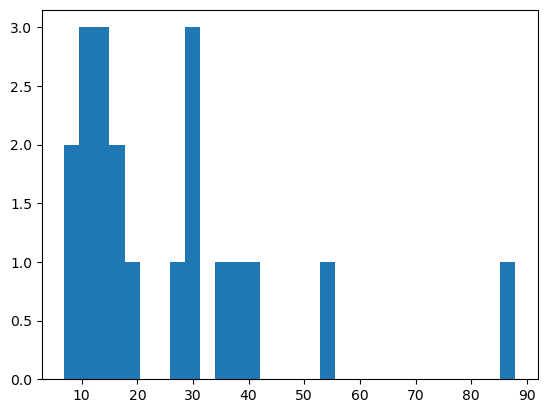

In [10]:
plt.hist(durations, bins=30);

In [4]:
# Matches the dataset length once individually treated exp is added! 
df_csvs["num_frames"].sum() + 2638

14508

In [15]:
# cnum_frames = df_csvs.num_frames.tolist()
# dnum_frames = []
# for nth, nf in enumerate(cnum_frames):
#     if int(nth) in downsample_idx:
#         dnum_frames.append(nf/2)
#     else:
#         dnum_frames.append(nf)
# print(sum(dnum_frames)+2634)

        
# downsampled ABOVE on dataframe basis
# if int(nth) in downsample_idx:  # downsample 60 to 30fps
#     extents, input_image_paths, mask_filepaths = extents[::2], input_image_paths[::2], mask_filepaths[::2]
#     centers_of_mass = centers_of_mass[::2]

10651.0


# 1. Masking Images and Export Bbox

In [ ]:
target_size = (224, 224)
files = df_csvs["files"].to_list()

PROCESS_IMAGES = False
if PROCESS_IMAGES:
    for nth, file in enumerate(files):
        
        # Load df and variables
        df = pd.read_csv(os.path.join(stats_path, file))
        extents, input_image_paths, mask_filepaths = df[["extent", "img_fp", "mask_fp"]].T.values.tolist()
        centers_of_mass = list(df[["centroid_y", "centroid_x"]].itertuples(index=False, name=None))        
        max_extent = int(np.percentile(extents, 98))

        # Export with rgb with bg masked as gray
        # output_image_paths = [fp.replace("images/", f"images/resized_cropped_squarebbox_rgb_gbg_{target_size[0]}/") for fp in input_image_paths]
        # process_images_with_masks(input_image_paths, mask_filepaths, centers_of_mass, max_extent, target_size, output_image_paths);
        
        # Export rgb with bg
        output_image_paths = [fp.replace("images/", f"images/resized_cropped_squarebbox_rgb_bg_{target_size[0]}/") for fp in input_image_paths]
        process_images_with_extents(input_image_paths, centers_of_mass, max_extent, target_size, output_image_paths);
            